*This notebook plots the distribution of probes that witness 2-levels and 3-levels of interleaving depth level changes*
- - - 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates

In [3]:
DB_LOCATION = 'lastmile.db'

In [4]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [5]:
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
SK_ASN = 'sk_asn'
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'

In [6]:
con = sqlite3.connect(DB_LOCATION)

In [7]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , s.asn
                        , s.asn_holder_name
                        , s.asn_access_type
                        , agg.h1_median as h1
                        , agg.h2_median as h2                        

               FROM   %s                             as  agg
                    , %s                             as  api               
                    , %s                             as  s                  
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn_v4                   =  s.asn
               

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1
               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [8]:
df_ra.count()

probeid            134724
timestamp          134724
asn                134724
asn_holder_name    134724
asn_access_type    134724
h1                 133920
h2                 130563
dtype: int64

In [9]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,asn_access_type,h1,h2
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.429,20.490
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.431,17.700
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.438,17.776
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.478,17.577
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,0.422,17.526


In [10]:
query_sk = ''' SELECT     agg.probeid
                        , agg.timestamp
                        , s.asn 
                        , s.asn_access_type
                        , s.asn_holder_name
                        , meta.product                        
                        , agg.h1_avg as h1
                        , agg.h2_avg as h2
                                                                                     
               FROM       %s                            as   agg
                        , %s                            as   api               
                        , %s                            as   ext
                        , %s                            as   s
                        , %s                            as   meta
                        
                        

               WHERE      agg.probeid                    =    ext.probeid
               AND        agg.probeid                    =    api.probeid
               AND        agg.probeid                    =    meta.id               
               AND        api.asn                        =    s.asn               
               
               AND        ext.if_residential             =    1
               AND        agg.h1_avg                     <>   0
               AND        agg.h2_avg                     <>   0
               
           '''%(   SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS                
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN        
                 , METADATA_SNAPSHOT                
               )

df_sk = pd.read_sql(query_sk, con)

In [11]:
df_ra = df_ra.dropna()

In [12]:
df_sk = df_sk.dropna()

In [13]:
df_sk.count()

probeid            415903
timestamp          415903
asn                415903
asn_access_type    415903
asn_holder_name    415903
product            415903
h1                 415903
h2                 415903
dtype: int64

In [14]:
df_ra.count()

probeid            130006
timestamp          130006
asn                130006
asn_holder_name    130006
asn_access_type    130006
h1                 130006
h2                 130006
dtype: int64

In [15]:
df_ra = df_ra[df_ra.asn_access_type == 'DSL']
df_sk = df_sk[df_sk.asn_access_type == 'DSL']

In [16]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

In [17]:
df_ra_groupby = df_ra.groupby(['asn', 'asn_holder_name'])
df_sk_groupby = df_sk.groupby(['asn', 'asn_holder_name'])

In [18]:
from scipy.cluster.vq import kmeans
from scipy.signal import argrelextrema

def calculate_kde(df):

    x = df.sort('h2')['h2'].values
    from scipy.stats import kde    
    try: density = kde.gaussian_kde(x)
    except Exception as e: print(e, type(e), key, end=''); return None
    else: 
        xgrid = np.linspace(x.min(), x.max(), len(x))   
        ygrid = density(xgrid)
        return xgrid, ygrid
        
def calculate_kde_peaks(df):
    
    xgrid, ygrid = calculate_kde(df)
    maximas_indexes = argrelextrema(ygrid, np.greater)[0]
    max_y = ygrid[maximas_indexes]        
    max_x = xgrid[maximas_indexes]
    zipped_x_y = zip(max_x, max_y)
    peaks = []
    prev = None; interval = False
    for x, y in zipped_x_y:
        if prev is None: interval = True
        if prev is not None: 
            if abs(x - prev) < 5: continue
            else: interval = True
        if interval:
            prev = x
            if y >= 0.01: peaks.append((x,y))
    return (peaks)

In [19]:
def start_plot():    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(9,5))
    plt.rcParams['font.size'] = 22
    ax = fig.add_subplot(111)
    return ax

def stop_plot_cdf(ax, chosen, count):
    
    ax.grid(True)
    ax.set_xlim([0.25, 64])    
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Latency (ms)', fontsize=22)
    ax.set_ylabel('CDF', fontsize=22)
    plt.legend(loc='best', fontsize=22)
    plt.title('%s (RIPE Atlas)'%(chosen), fontsize=22, y=1.05)

In [20]:
def add_to_d(df_groupby):
    d = {}
    for i, (key, group) in enumerate(df_groupby):
        asn, holder_name = key; draw=False
        nodename = create_pretty_node_names(asn, holder_name)
        df_groupby_probeid = group.groupby('probeid')

        for j, (probeid, group) in enumerate(df_groupby_probeid):
            if group['timestamp'].count() <= 1: continue
            try: peaks = calculate_kde_peaks(group)
            except Exception as e: print(e)
            if len(peaks) <= 1: continue
            print('.', end='')
            try: d[len(peaks)].append(probeid)
            except Exception as e: d[len(peaks)] = [probeid]
    return d

In [21]:
d_ra = add_to_d(df_ra_groupby)
d_sk = add_to_d(df_sk_groupby)

...................................................................................................................................

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [24]:
df_ra_groupby = df_ra.groupby('probeid')
df_agg = df_ra_groupby.agg([len])
df_ra_merge = pd.merge(df_ra, df_agg, left_on="probeid", right_index=True)
df_ra_merge_cut = df_ra_merge.iloc[:,[0,2,3]]
df_ra_probes = df_ra_merge_cut.drop_duplicates()

In [25]:
df_sk_groupby = df_sk.groupby('probeid')
df_agg = df_sk_groupby.agg([len])
df_sk_merge = pd.merge(df_sk, df_agg, left_on="probeid", right_index=True)
df_sk_merge_cut = df_sk_merge.iloc[:,[0,2,4]]
df_sk_probes = df_sk_merge_cut.drop_duplicates()

In [26]:
df_ra_probes.count()

probeid            451
asn                451
asn_holder_name    451
dtype: int64

In [27]:
df_sk_probes.count()

probeid            986
asn                986
asn_holder_name    986
dtype: int64

In [28]:
def get_depth_level(d, probeid):
    for k, v in d.items():
        if probeid in v: return k
    return 1

def get_ra_depth_level(probeid): return get_depth_level(d_ra, probeid)
def get_sk_depth_level(probeid): return get_depth_level(d_sk, probeid)   
    
df_ra_probes['level'] = df_ra_probes['probeid'].apply(get_ra_depth_level)
df_sk_probes['level'] = df_sk_probes['probeid'].apply(get_sk_depth_level)

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
df_ra_probes.head()

,probeid,asn,asn_holder_name,level
0,10006,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1
570,10012,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1
778,10013,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1
986,10015,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1
1194,10022,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1


In [30]:
df_sk_probes.head()

,probeid,asn,asn_holder_name,level
0,14905,2856,"BT-UK-AS BT Public Internet Service,GB",1
418,14971,12576,ORANGE-PCS Orange Personal Communications Serv...,1
564,15015,2856,"BT-UK-AS BT Public Internet Service,GB",1
978,15058,2856,"BT-UK-AS BT Public Internet Service,GB",1
1304,15129,6871,"PLUSNET PlusNet PLC,GB",1


In [31]:
import Cdf

markers = ['d', 'x', '+', 'o', 'p', 'v', '8', '*', 'D', '<', 's']

def draw_cdf(df):
    
    sample = df['level'].values
    c = Cdf.MakeCdfFromList(sample)
    
    print(c.xs, c.ps)
    plt.plot (  c.xs
              , c.ps
              , marker='s'
              , linewidth=0.3
              , color='Red'
              , markersize=15
              , fillstyle='none'
             )

In [36]:
df_sk_probes[df_sk_probes.level == 3]

,probeid,asn,asn_holder_name,level
54245,141012,2856,"BT-UK-AS BT Public Internet Service,GB",3
90763,142056,2856,"BT-UK-AS BT Public Internet Service,GB",3
96334,142920,2856,"BT-UK-AS BT Public Internet Service,GB",3
105848,143082,13285,"OPALTELECOM-AS TalkTalk Communications Limited,GB",3
123386,143268,2856,"BT-UK-AS BT Public Internet Service,GB",3
231957,146314,2856,"BT-UK-AS BT Public Internet Service,GB",3
236809,146358,13285,"OPALTELECOM-AS TalkTalk Communications Limited,GB",3
280620,147230,2856,"BT-UK-AS BT Public Internet Service,GB",3
282214,147250,2856,"BT-UK-AS BT Public Internet Service,GB",3
292598,147542,2856,"BT-UK-AS BT Public Internet Service,GB",3


In [37]:
df_sk_probes.count()

probeid            986
asn                986
asn_holder_name    986
level              986
dtype: int64

In [38]:
df_ra_probes.count()

probeid            451
asn                451
asn_holder_name    451
level              451
dtype: int64

In [39]:
def get_levels_by_asn(df):
    df_groupby = df.groupby(['asn', 'level'])
    df_groupby_agg = df_groupby.agg([len])
    df_merge = pd.merge(  df
                        , df_groupby_agg
                        , left_on=['asn', 'level']
                        , right_index=True
                       )
    del df_merge['probeid']
    df_levels = df_merge.drop_duplicates()
    df_levels = df_levels.sort('asn')
    return df_levels

In [40]:
df_ra_levels = get_levels_by_asn(df_ra_probes)
df_sk_levels = get_levels_by_asn(df_sk_probes)

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [41]:
df_ra_levels.head()

,asn,asn_holder_name,level,"(probeid, len)","(asn_holder_name, len)"
6346,701,"UUNET - MCI Communications Services, Inc. d/b/...",1,23,23
1811,2856,"BT-UK-AS BT Public Internet Service,GB",1,23,23
3955,3209,"VODANET Vodafone GmbH,DE",1,10,10
24705,3215,"AS3215 Orange S.A.,FR",1,60,60
0,3265,"XS4ALL-NL XS4ALL Internet BV,NL",1,29,29


In [42]:
df_sk_levels.head()

,asn,asn_holder_name,level,"(probeid, len)","(asn_holder_name, len)"
0,2856,"BT-UK-AS BT Public Internet Service,GB",1,264,264
6056,2856,"BT-UK-AS BT Public Internet Service,GB",2,40,40
54245,2856,"BT-UK-AS BT Public Internet Service,GB",3,10,10
173243,5607,BSKYB-BROADBAND-AS British Sky Broadcasting Li...,2,1,1
15622,5607,BSKYB-BROADBAND-AS British Sky Broadcasting Li...,1,35,35


In [43]:
df_ra_levels = df_ra_levels.apply(myfunc, axis=1)
df_sk_levels = df_sk_levels.apply(myfunc, axis=1)

In [44]:
del df_ra_levels['asn']; del df_ra_levels['asn_holder_name'];
del df_sk_levels['asn']; del df_sk_levels['asn_holder_name'];

In [45]:
df_ra_levels.head()

,level,"(probeid, len)","(asn_holder_name, len)",nodename
6346,1,23,23,UUNET (AS701)
1811,1,23,23,BT (AS2856)
3955,1,10,10,VODAFONE (AS3209)
24705,1,60,60,ORANGE (AS3215)
0,1,29,29,XS4ALL (AS3265)


In [46]:
df_sk_levels.head()

,level,"(probeid, len)","(asn_holder_name, len)",nodename
0,1,264,264,BT (AS2856)
6056,2,40,40,BT (AS2856)
54245,3,10,10,BT (AS2856)
173243,2,1,1,BSKYB (AS5607)
15622,1,35,35,BSKYB (AS5607)


In [47]:
df_ra_levels.rename(columns={df_ra_levels.columns[1]: 'probes'}, inplace=True)
df_sk_levels.rename(columns={df_sk_levels.columns[1]: 'probes'}, inplace=True)

In [48]:
df_ra = df_ra_levels.iloc[:,[0,1,3]]
df_sk = df_sk_levels.iloc[:,[0,1,3]]

In [49]:
df_ra.head(n=10)

,level,probes,nodename
6346,1,23,UUNET (AS701)
1811,1,23,BT (AS2856)
3955,1,10,VODAFONE (AS3209)
24705,1,60,ORANGE (AS3215)
0,1,29,XS4ALL (AS3265)
17953,2,1,XS4ALL (AS3265)
1400,1,60,DTAG (AS3320)
92869,2,1,DTAG (AS3320)
13375,1,23,BELGACOM (AS5432)
20046,2,1,BELGACOM (AS5432)


In [50]:
df_sk.head(n=10)

,level,probes,nodename
0,1,264,BT (AS2856)
6056,2,40,BT (AS2856)
54245,3,10,BT (AS2856)
173243,2,1,BSKYB (AS5607)
15622,1,35,BSKYB (AS5607)
1304,1,261,PLUSNET (AS6871)
128310,2,10,PLUSNET (AS6871)
4800,2,12,TISCALI (AS9105)
20588,1,60,TISCALI (AS9105)
324427,3,1,TISCALI (AS9105)


In [51]:
def split_by_levels(df):
    df['l1'] = 0; df['l2'] = 0; df['l3'] = 0
    for index, row in df.iterrows():
        try: l = row['level']; count = row['probes']
        except Exception as e: print(e, type(e))
        else: df.ix[index, 'l%d'%l] = count
    return df

In [52]:
df_ra = split_by_levels(df_ra)
df_sk = split_by_levels(df_sk)

In [53]:
df_ra.count()

level       20
probes      20
nodename    20
l1          20
l2          20
l3          20
dtype: int64

In [54]:
df_sk.count()

level       22
probes      22
nodename    22
l1          22
l2          22
l3          22
dtype: int64

In [55]:
del df_ra['level']; del df_ra['probes']
del df_sk['level']; del df_sk['probes']

In [56]:
df_ra.head(n=10)

,nodename,l1,l2,l3
6346,UUNET (AS701),23,0,0
1811,BT (AS2856),23,0,0
3955,VODAFONE (AS3209),10,0,0
24705,ORANGE (AS3215),60,0,0
0,XS4ALL (AS3265),29,0,0
17953,XS4ALL (AS3265),0,1,0
1400,DTAG (AS3320),60,0,0
92869,DTAG (AS3320),0,1,0
13375,BELGACOM (AS5432),23,0,0
20046,BELGACOM (AS5432),0,1,0


In [57]:
df_sk.head(n=10)

,nodename,l1,l2,l3
0,BT (AS2856),264,0,0
6056,BT (AS2856),0,40,0
54245,BT (AS2856),0,0,10
173243,BSKYB (AS5607),0,1,0
15622,BSKYB (AS5607),35,0,0
1304,PLUSNET (AS6871),261,0,0
128310,PLUSNET (AS6871),0,10,0
4800,TISCALI (AS9105),0,12,0
20588,TISCALI (AS9105),60,0,0
324427,TISCALI (AS9105),0,0,1


In [58]:
def merge_levels(df):
    df_gby = df.groupby('nodename')
    df_gby_agg = df_gby.agg([sum])
    df_gby_merged = pd.merge(  df
                             , df_gby_agg
                             , left_on='nodename'
                             , right_index=True
                            )

    del df_gby_merged['l1']; 
    del df_gby_merged['l2']; 
    del df_gby_merged['l3'];

    df = df_gby_merged.drop_duplicates()

    df.rename(  columns={  df.columns[1]: 'l1'
                         , df.columns[2]: 'l2'
                         , df.columns[3]: 'l3'                   
                        }
                 , inplace=True
             )
    return df

In [59]:
df_ra = merge_levels(df_ra)
df_sk = merge_levels(df_sk)

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [60]:
df_ra.head(n=20)

,nodename,l1,l2,l3
6346,UUNET (AS701),23,0,0
1811,BT (AS2856),23,0,0
3955,VODAFONE (AS3209),10,0,0
24705,ORANGE (AS3215),60,0,0
0,XS4ALL (AS3265),29,1,0
1400,DTAG (AS3320),60,1,0
13375,BELGACOM (AS5432),23,1,0
50853,TELEFONICA-DE (AS6805),11,2,0
15250,FREE (AS12322),125,12,0
46481,ZEN (AS13037),10,2,0


In [61]:
df_sk.head(n=20)

,nodename,l1,l2,l3
0,BT (AS2856),264,40,10
173243,BSKYB (AS5607),35,1,0
1304,PLUSNET (AS6871),261,10,0
4800,TISCALI (AS9105),60,12,1
2522,ECLIPSE (AS12513),6,0,0
40875,ORANGE (AS12576),73,8,1
156741,ZEN (AS13037),33,2,0
20200,OPALTELECOM (AS13285),109,21,2
14242,AS20712 (AS20712),3,0,0
44826,TALKTALK (AS43234),32,2,0


In [62]:
df_ra = df_ra.sort('l2')
df_sk = df_sk.sort('l2')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [63]:
df_ra = df_ra.reset_index()
df_sk = df_sk.reset_index()
del df_ra['index']; del df_sk['index']

In [64]:
df_ra.head(n=50)

,nodename,l1,l2,l3
0,UUNET (AS701),23,0,0
1,BT (AS2856),23,0,0
2,VODAFONE (AS3209),10,0,0
3,ORANGE (AS3215),60,0,0
4,XS4ALL (AS3265),29,1,0
5,DTAG (AS3320),60,1,0
6,BELGACOM (AS5432),23,1,0
7,LDCOMNET (AS15557),28,1,0
8,OVH (AS35540),28,1,0
9,TELEFONICA-DE (AS6805),11,2,0


In [65]:
df_sk.head(n=50)

,nodename,l1,l2,l3
0,ECLIPSE (AS12513),6,0,0
1,AS20712 (AS20712),3,0,0
2,BSKYB (AS5607),35,1,0
3,ZEN (AS13037),33,2,0
4,TALKTALK (AS43234),32,2,0
5,ORANGE (AS12576),73,8,1
6,PLUSNET (AS6871),261,10,0
7,TISCALI (AS9105),60,12,1
8,OPALTELECOM (AS13285),109,21,2
9,BT (AS2856),264,40,10


In [68]:
df = pd.concat([df_ra, df_sk])

In [69]:
df_l2 = df[df.l2 > 0]
df_l2 = df_l2.sort('l2')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [70]:
df_l3 = df[df.l3 > 0]
df_l3 = df_l3.sort('l3')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [71]:
df_l2

,nodename,l1,l2,l3
4,XS4ALL (AS3265),29,1,0
5,DTAG (AS3320),60,1,0
6,BELGACOM (AS5432),23,1,0
7,LDCOMNET (AS15557),28,1,0
8,OVH (AS35540),28,1,0
2,BSKYB (AS5607),35,1,0
9,TELEFONICA-DE (AS6805),11,2,0
10,ZEN (AS13037),10,2,0
3,ZEN (AS13037),33,2,0
4,TALKTALK (AS43234),32,2,0


In [72]:
df_l2 = merge_levels(df_l2)
df_l2 = df_l2.sort('l2')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [73]:
df_l3 = merge_levels(df_l3)
df_l3 = df_l3.sort('l3')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [74]:
df_l2 = df_l2.reset_index(); df_l3 = df_l3.reset_index()
del df_l2['index']; del df_l3['index']

In [75]:
df_l2['nodename'] = df_l2['nodename'].apply(lambda x: x.split()[0])
df_l3['nodename'] = df_l3['nodename'].apply(lambda x: x.split()[0])

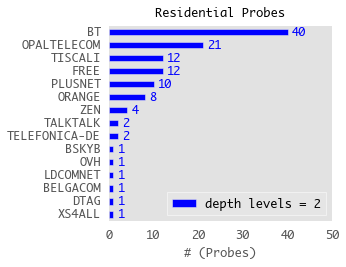

In [92]:
plt.style.use('ggplot')
plt.figure()
plt.rcParams['font.size'] = 12

xticks = [i for i in range(0, 60, 10)]

ax = df_l2.plot(  kind='barh'
                , x='nodename'
                , y=['l2']
                , xticks=xticks
                , stacked=False
                , legend=None
                , figsize=(4,3.5)
                , grid=False
               );

for idx, label in enumerate(df_l2.index):
    pos      = df_l2.ix[idx][0]
    l2_value = df_l2.ix[idx][2]
    try: 
        plt.annotate(str(l2_value), xy=(l2_value + 1, idx), va='center', fontsize=12, color='blue')            
    except Exception as e: print(e, type(e), value)

ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_axis_bgcolor('#E2E2E2')    
plt.xlim(0,max(xticks))
plt.xlabel('# (Probes)', fontsize=12)
plt.ylabel('')
plt.legend(["depth levels = 2"], loc='lower right', fontsize=12)
plt.title('Residential Probes', fontsize=12, y=1.02)
plt.savefig('interleaving-depth-level2.pdf', format='pdf', bbox_inches='tight')

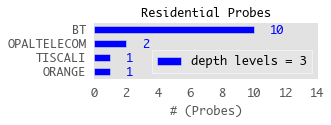

In [91]:
plt.style.use('ggplot')
plt.figure()
plt.rcParams['font.size'] = 12

xticks = [i for i in range(0, 15, 2)]

ax = df_l3.plot(  kind='barh'
                , x='nodename'
                , y=['l3']
                , xticks=xticks
                , stacked=False
                , legend=None
                , figsize=(4,1)
                , grid=False
               );

for idx, label in enumerate(df_l3.index):
    pos      = df_l3.ix[idx][0]
    l3_value = df_l3.ix[idx][3]
    try: 
        plt.annotate(str(l3_value), xy=(l3_value + 1, idx), va='center', fontsize=12, color='blue')            
    except Exception as e: print(e, type(e), value)

ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_axis_bgcolor('#E2E2E2')    
plt.xlim(0,max(xticks))
plt.xlabel('# (Probes)', fontsize=12)
plt.ylabel('')
plt.legend(["depth levels = 3"], loc='lower right', fontsize=12)
plt.title('Residential Probes', fontsize=12, y=1.02)
plt.savefig('interleaving-depth-level3.pdf', format='pdf', bbox_inches='tight')